<a href="https://colab.research.google.com/github/bb20417/CE888/blob/main/assignment2/tweetClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import important libraries

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import csv
import matplotlib.pyplot as plt


In [2]:
import seaborn as sns
import re
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import  CountVectorizer, TfidfVectorizer
from sklearn import svm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical


In [3]:
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


My chosen datasets are: **Offensive language identification, Hate speech detection and Emotion recongnition**

# Loading all the datasets.

Total 21 datasets

## Loading *Emotion datasets*

In [4]:

#traindf=pd.read_csv('../input/semeval-2018-task-ec/2018-E-c-En-train.txt',encoding='utf-8',sep="\t")
emo_train_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt",encoding='utf-8',sep="\t", header=None)
emo_train_text.columns= ["tweet_text"]
emo_train_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt",encoding='utf-8',sep="\t", header=None)
emo_train_label.columns= ["tweet_label"]


emo_val_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_text.txt",encoding='utf-8',sep="\t", header=None)
emo_val_text.columns= ["tweet_text"]
emo_val_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_labels.txt",encoding='utf-8',sep="\t", header=None)
emo_val_label.columns= ["tweet_label"]

emo_test_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt",encoding='utf-8',sep="\t", header=None)
emo_test_text.columns= ["tweet_text"]
emo_test_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt",encoding='utf-8',sep="\t", header=None)
emo_test_label.columns= ["tweet_label"]

emo_map = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt",encoding='utf-8',sep="\t", header=None)
emo_map.columns= ["tweet_label","emotion"]


## Loading *Hate datasets*

In [5]:
#loading Hate speech data
hate_train_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_text.txt", sep="\t", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_train_text.columns= ["tweet_text"]
hate_train_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_labels.txt",encoding='utf-8',sep="\n", header=None)
hate_train_label.columns= ["tweet_label"]


hate_val_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_text.txt",sep="\t", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_val_text.columns= ["tweet_text"]
hate_val_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_labels.txt",encoding='utf-8',sep="\t", header=None)
hate_val_label.columns= ["tweet_label"]

hate_test_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_text.txt",sep="\t", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_test_text.columns= ["tweet_text"]
hate_test_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_labels.txt",encoding='utf-8',sep="\t", header=None)
hate_test_label.columns= ["tweet_label"]

hate_map = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/mapping.txt",encoding='utf-8',sep="\t", header=None)
hate_map.columns= ["tweet_label","isHate"]

## Loading *Offensive datasets*

In [6]:
#loading offensive data
off_train_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_text.txt",encoding='utf-8',sep="\t", header=None)
off_train_text.columns= ["tweet_text"]
off_train_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_labels.txt",encoding='utf-8',sep="\t", header=None)
off_train_label.columns= ["tweet_label"]


off_val_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_text.txt",encoding='utf-8',sep="\t", header=None)
off_val_text.columns= ["tweet_text"]
off_val_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_labels.txt",encoding='utf-8',sep="\t", header=None)
off_val_label.columns= ["tweet_label"]

off_test_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_text.txt",encoding='utf-8',sep="\t", header=None)
off_test_text.columns= ["tweet_text"]
off_test_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_labels.txt",encoding='utf-8',sep="\t", header=None)
off_test_label.columns= ["tweet_label"]


off_map = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/mapping.txt",encoding='utf-8',sep="\t", header=None)
off_map.columns= ["tweet_label","offensive"]

# Cleaning methods used by all datasets

# **Emotion** dataset

## *Preprocessing*


In [7]:
#concatenating dataframe by columns to make one dataset each for train, validation and test df
df_emo_train = pd.concat([emo_train_text,emo_train_label], axis=1)
df_emo_val = pd.concat([emo_val_text,emo_val_label], axis=1)
df_emo_test = pd.concat([emo_test_text,emo_test_label], axis=1)

In [8]:
#joining mapping dataset with train, validation and test datasets
emo_combo_train = pd.merge(df_emo_train,emo_map, on='tweet_label')
emo_combo_val = pd.merge(df_emo_val,emo_map, on='tweet_label')
emo_combo_test = pd.merge(df_emo_test,emo_map, on='tweet_label')

In [9]:
# concatenating train and validation datasets by row to make one complete training data
emo_train_val = pd.concat([emo_combo_train,emo_combo_val])

## *Visualization*

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

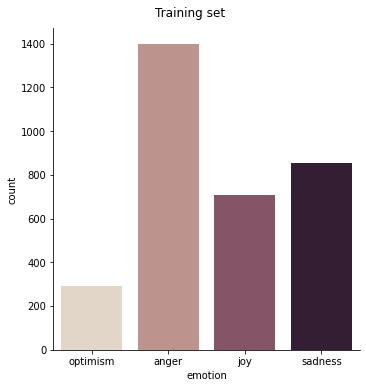

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

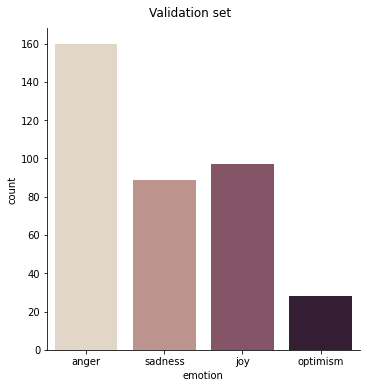

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

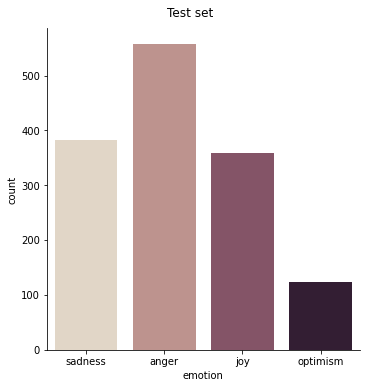

In [10]:
from google.colab import files
g = (sns.catplot(x="emotion", kind="count", palette="ch:.25", data=emo_combo_train))
g.fig.suptitle("Training set", y=1.03)
g.savefig("emo_train1.png")
files.download("emo_train1.png")
plt.show()

v = sns.catplot(x="emotion", kind="count", palette="ch:.25", data=emo_combo_val)
v.fig.suptitle("Validation set", y=1.03)
v.savefig("emo_val.png")
files.download("emo_val.png")
plt.show()

t = sns.catplot(x="emotion", kind="count", palette="ch:.25", data=emo_combo_test)
t.fig.suptitle("Test set", y=1.03)
t.savefig("emo_test.png")
files.download("emo_test.png")

plt.show()



all the three datasets are similarly unbalanced.

**Wordclouds**

In [ ]:
#creating different datasets for different emotions
emo_sad = emo_combo_train[emo_combo_train['emotion'] == 'sadness']['tweet_text']
emo_anger = emo_combo_train[emo_combo_train['emotion'] == 'anger']['tweet_text']
emo_joy = emo_combo_train[emo_combo_train['emotion'] == 'joy']['tweet_text']
emo_opt = emo_combo_train[emo_combo_train['emotion'] == 'optimism']['tweet_text']

In [ ]:
emo_sad

2402    it's pretty depressing when u hit pan on ur fa...
2403    Making that yearly transition from excited and...
2404    #NewYork: Several #Baloch &amp; Indian activis...
2405    It’s possible changing meds is best not done w...
2406    @user oh I see. I've seen so many people mourn...
                              ...                        
3252    @user @user @user haha Bro she's sadly married...
3253    If i could just get my line to block! #germant...
3254    I wouldn't wish anxiety and depression even on...
3255    I get discouraged because I try for 5 fucking ...
3256    The @user are in contention and hosting @user ...
Name: tweet_text, Length: 855, dtype: object

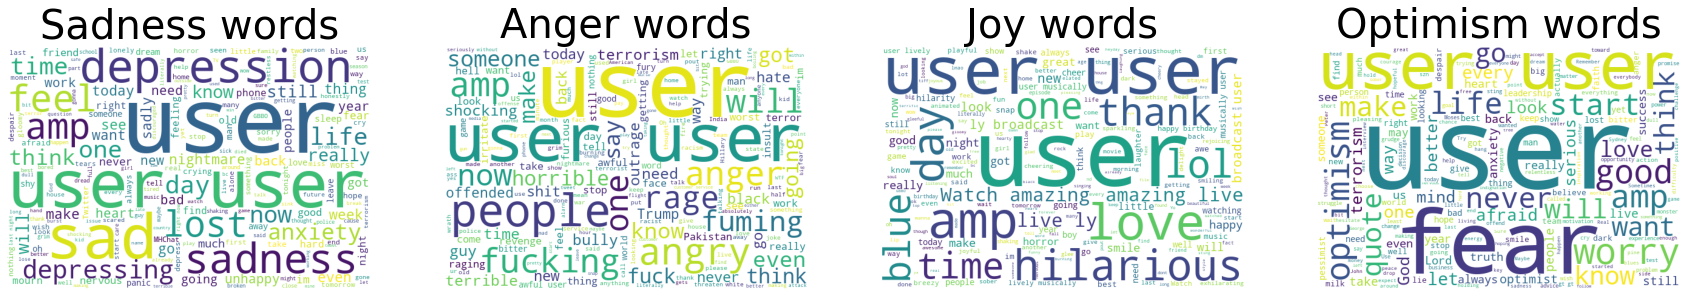

In [ ]:
#creating wordclouds for different classes of Emotion
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[30, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(emo_sad))
# wordcloud1.to_file('sad_cloud.png')
# files.download('sad_cloud.png')

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Sadness words',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(emo_anger))
# wordcloud2.to_file('anger_cloud.png')
# files.download('anger_cloud.png')

ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Anger words',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(emo_joy))
# wordcloud3.to_file('joy_cloud.png')
# files.download('joy_cloud.png')

ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Joy words',fontsize=40);

wordcloud4 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(emo_opt))
#wordcloud4.to_file('opt_cloud.png')
#files.download('opt_cloud.png')

ax4.imshow(wordcloud4)
ax4.axis('off')
ax4.set_title('Optimism words',fontsize=40);


 

In [ ]:
# Source of code: https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert/notebook

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



In [ ]:
#getting top 20 words in each classification of Emotion
top_sad_words = get_top_n_words(emo_sad)
top_angry_words = get_top_n_words(emo_anger)
top_joy_words = get_top_n_words(emo_joy)
top_op_words = get_top_n_words(emo_opt)

s1 = [x[0] for x in top_sad_words[:20]]
s2 = [x[1] for x in top_sad_words[:20]]

a1 = [x[0] for x in top_angry_words[:20]]
a2 = [x[1] for x in top_angry_words[:20]]

j1 = [x[0] for x in top_joy_words[:20]]
j2 = [x[1] for x in top_joy_words[:20]]

o1 = [x[0] for x in top_op_words[:20]]
o2 = [x[1] for x in top_op_words[:20]]


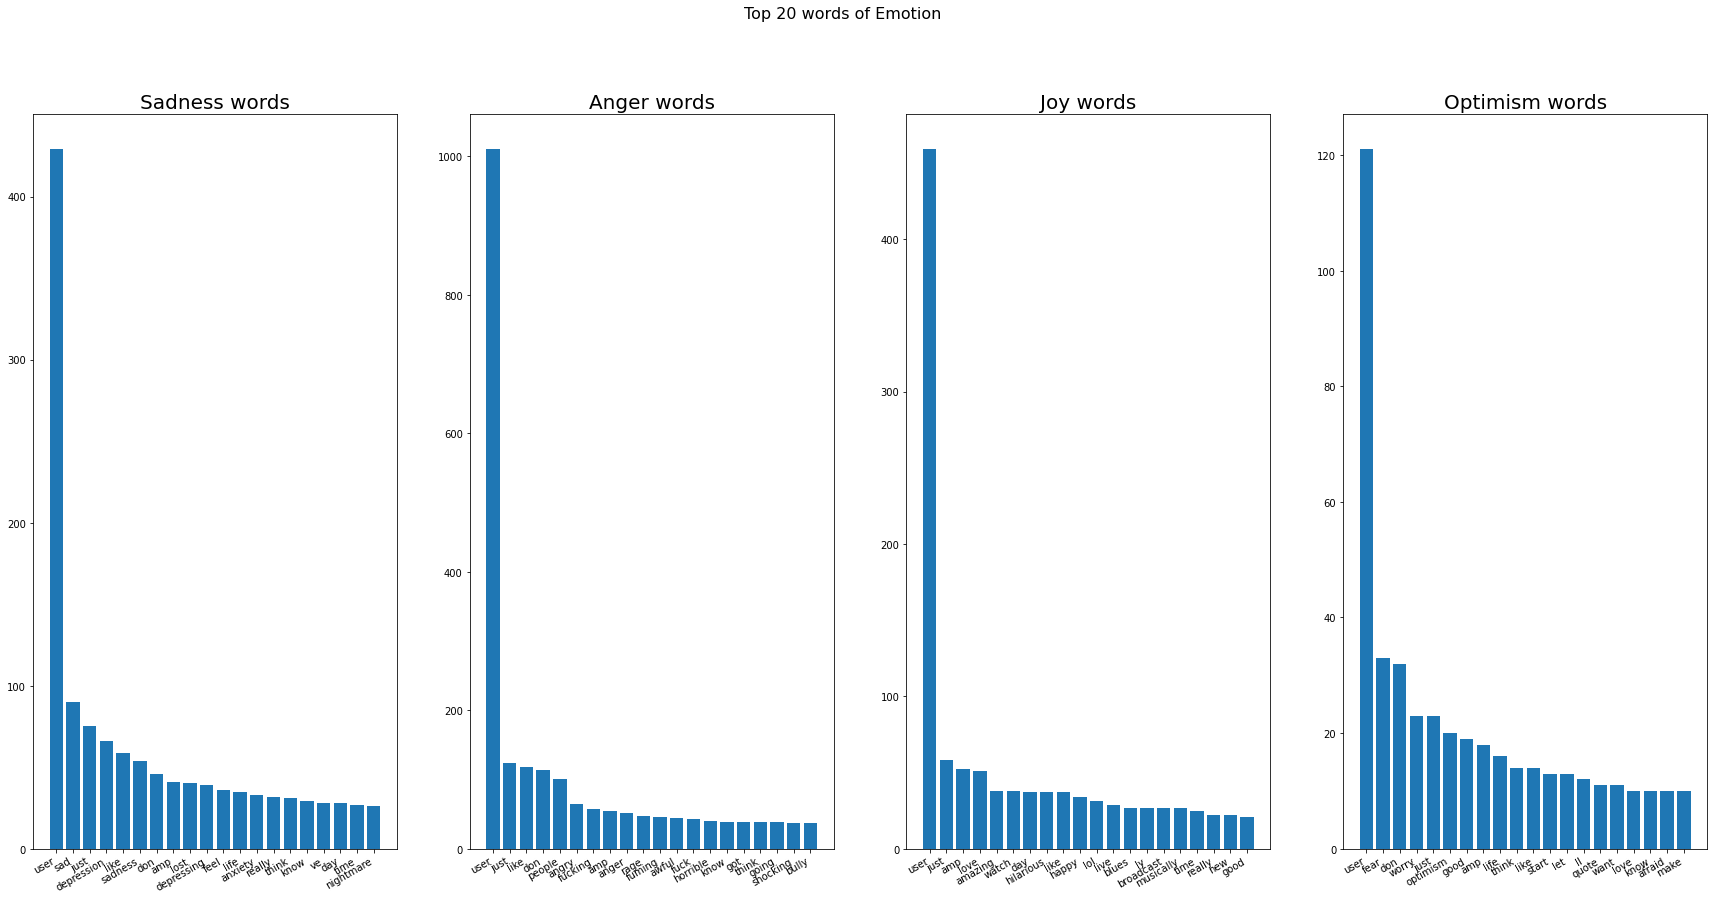

In [ ]:
#visualization for top 20 words in each classification of Emotion

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[30, 15])
fig.suptitle('Top 20 words of Emotion',fontsize=16)
ax1.bar(s1, s2)
ax1.set_title('Sadness words',fontsize=20);
fig.autofmt_xdate()

ax2.bar(a1,a2)
ax2.set_title('Anger words',fontsize=20);
fig.autofmt_xdate()

ax3.bar(j1,j2)
ax3.set_title('Joy words',fontsize=20);
fig.autofmt_xdate()

ax4.bar(o1,o2)
ax4.set_title('Optimism words',fontsize=20);
fig.autofmt_xdate()



## *Training* the model and testing with macro averaged F1 score as evaluation metric.

### Data Cleaning

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

train_data = emo_train_val[['tweet_text','emotion']]
test_data = emo_combo_test[['tweet_text','emotion']]

# Setting stopwords
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

# Function to expand tweet
def expand_tweet(tweet):
	expanded_tweet = []
	for word in tweet:
		if re.search("n't", word):
			expanded_tweet.append(word.split("n't")[0])
			expanded_tweet.append("not")
		else:
			expanded_tweet.append(word)
	return expanded_tweet

# Function to process tweets
def clean_tweet(data, wordNetLemmatizer, porterStemmer):
	data['Clean_tweet'] = data['tweet_text']
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
	data['Clean_tweet'] = data['Clean_tweet'].str.split()
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [word for word in tweet if word not in STOPWORDS])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: expand_tweet(tweet))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [wordNetLemmatizer.lemmatize(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [porterStemmer.stem(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: ' '.join(tweet))
	return data


wordNetLemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

# pre-processing the tweets
train_data = clean_tweet(train_data, wordNetLemmatizer, porterStemmer)
test_data = clean_tweet(test_data, wordNetLemmatizer, porterStemmer)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['Clean_tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['Clean_tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['Clean_tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)




### Model Training and Testing

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Building the model
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(4, activation = 'softmax'))
#model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 128)           256000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 20, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 651,268
Trainable params: 651,268
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model
history = model.fit(train_tweets, pd.get_dummies(train_data['emotion']).values, epochs = 10, batch_size = 128)

# Testing the model

#score, accuracy = model.evaluate(test_tweets, pd.get_dummies(test_data['emotion']).values, batch_size = 128)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_tweets, pd.get_dummies(test_data['emotion']).values, batch_size = 128)
print("f1 score is {}".format(f1_score))

Epoch 1/10
29/29 [==============================] - 2s 12ms/step - loss: 1.3079 - accuracy: 0.3844 - f1_m: 0.0384 - precision_m: 0.1019 - recall_m: 0.0272
Epoch 2/10
29/29 [==============================] - 0s 11ms/step - loss: 1.1886 - accuracy: 0.4772 - f1_m: 0.1423 - precision_m: 0.4016 - recall_m: 0.0930
Epoch 3/10
29/29 [==============================] - 0s 11ms/step - loss: 0.8838 - accuracy: 0.6756 - f1_m: 0.5788 - precision_m: 0.8217 - recall_m: 0.4535
Epoch 4/10
29/29 [==============================] - 0s 10ms/step - loss: 0.6267 - accuracy: 0.7727 - f1_m: 0.7401 - precision_m: 0.8821 - recall_m: 0.6401
Epoch 5/10
29/29 [==============================] - 0s 10ms/step - loss: 0.4674 - accuracy: 0.8351 - f1_m: 0.8261 - precision_m: 0.9096 - recall_m: 0.7579
Epoch 6/10
29/29 [==============================] - 0s 10ms/step - loss: 0.3602 - accuracy: 0.8749 - f1_m: 0.8726 - precision_m: 0.9221 - recall_m: 0.8283
Epoch 7/10
29/29 [==============================] - 0s 10ms/step - los

# **Hate Speech** dataset

## *Preprocessing*


In [ ]:
#concatenating dataframe to make one dataset each for train, validation and test df
df_hate_train = pd.concat([hate_train_text,hate_train_label], axis=1)
df_hate_val = pd.concat([hate_val_text,hate_val_label], axis=1)
df_hate_test = pd.concat([hate_test_text,hate_test_label], axis=1)

In [ ]:
hate_combo_train = pd.merge(df_hate_train,hate_map, on='tweet_label')
hate_combo_val = pd.merge(df_hate_val,hate_map, on='tweet_label')
hate_combo_test = pd.merge(df_hate_test,hate_map, on='tweet_label')

In [ ]:
hate_train_val = pd.concat([hate_combo_train, hate_combo_val])

In [ ]:
#checking total nan values/ empty rows
total =0
for n in pd.isna(hate_train_val["tweet_text"]):
  if n==True:
    total = total+1
total

8

In [ ]:
hate_train_val.dropna(inplace=True) #dropping the empty tweets, total 8, as they were included during the reading part
hate_combo_test.dropna(inplace=True)

## *Visualization*

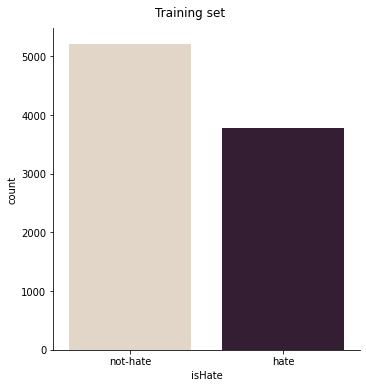

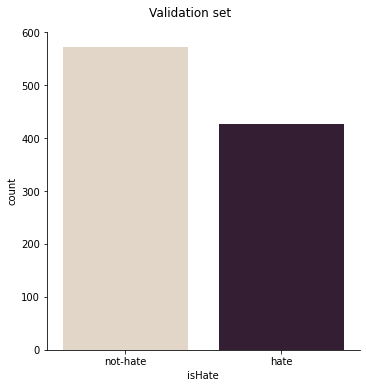

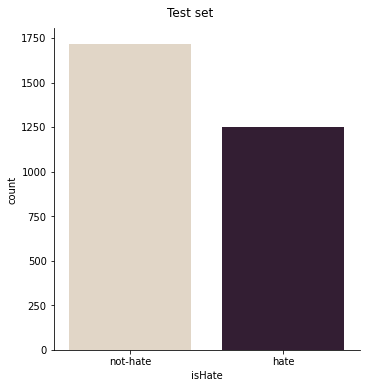

In [ ]:
g = (sns.catplot(x="isHate", kind="count", palette="ch:.25", data=hate_combo_train))
g.fig.suptitle("Training set", y=1.03)
# g.savefig("hate_train.png")
# files.download("hate_train.png")
plt.show()

v = sns.catplot(x="isHate", kind="count", palette="ch:.25", data=hate_combo_val)
v.fig.suptitle("Validation set", y=1.03)
# v.savefig("hate_val.png")
# files.download("hate_val.png")
plt.show()

t = sns.catplot(x="isHate", kind="count", palette="ch:.25", data=hate_combo_test)
t.fig.suptitle("Test set", y=1.03)
# t.savefig("hate_test.png")
# files.download("hate_test.png")
plt.show()


In [ ]:
#creating different datasets for different emotions
hate_yes = hate_train_val[hate_train_val['isHate'] == 'hate']['tweet_text']
hate_no =  hate_train_val[hate_train_val['isHate'] == 'not-hate']['tweet_text']


In [ ]:
hate_no


0      @user nice new signage. Are you not concerned ...
1                           Hysterical woman like @user 
2          Me flirting- So tell me about your father... 
3      The Philippine Catholic bishops' work for migr...
4                    When cuffin season is finally over 
                             ...                        
568                              @user Fry me you pussy 
569    Hundreds of arrests at DC protest against immi...
570    I've just entered MOBO Unsung with a remix of ...
571    imagine chaeyoung cutting some cooked meat for...
572    Large scale migration of illegal migrants to D...
Name: tweet_text, Length: 5782, dtype: object

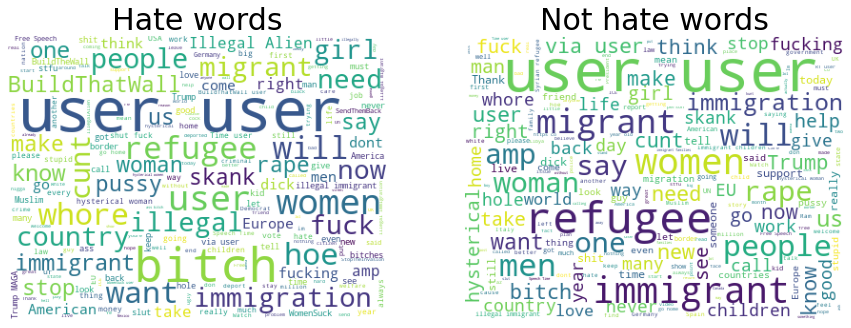

In [ ]:
# wordcloud for both classifications of Hate dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=400,
                        height=300).generate(" ".join(hate_yes))
# wordcloud1.to_file('hate_cloud.png')
# files.download('hate_cloud.png')

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Hate words',fontsize=30);

wordcloud2 = WordCloud(background_color='white',
                        width=400,
                        height=300).generate(" ".join(hate_no))
# wordcloud2.to_file('not_hate_cloud.png')
# files.download('not_hate_cloud.png')
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Not hate words',fontsize=30);



In [ ]:
#getting top 20 words in each classification of Hate dataset
top_hate_words = get_top_n_words(hate_yes)
top_nonHate_words = get_top_n_words(hate_no)


s1 = [x[0] for x in top_hate_words[:20]]
s2 = [x[1] for x in top_hate_words[:20]]

a1 = [x[0] for x in top_nonHate_words[:20]]
a2 = [x[1] for x in top_nonHate_words[:20]]



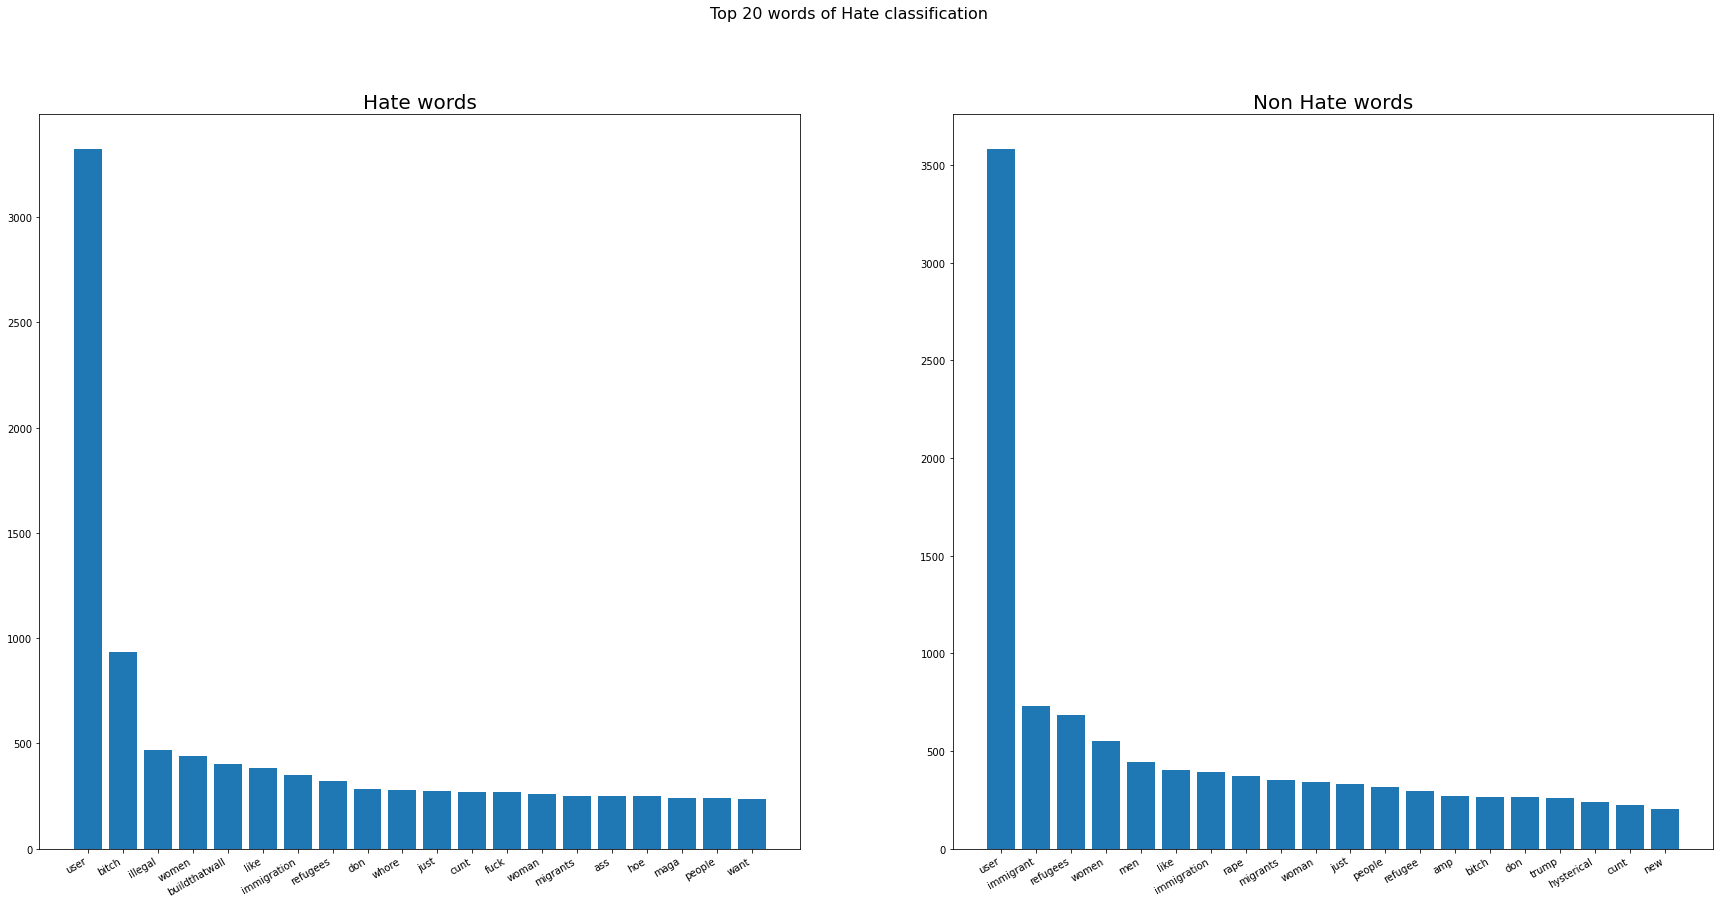

In [ ]:
#visualization for top 20 words in each classification of Hate dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
fig.suptitle('Top 20 words of Hate classification',fontsize=16)
ax1.bar(s1, s2)


ax1.set_title('Hate words',fontsize=20);
fig.autofmt_xdate()

ax2.bar(a1,a2)
ax2.set_title('Non Hate words',fontsize=20);
fig.autofmt_xdate()





## *Training* the model and testing with macro averaged F1 score as evaluation metric.

### Data Cleaning

In [ ]:
hate_combo_test[['tweet_text','isHate']]

,tweet_text,isHate
0,"@user , you are correct that Reid certainly is...",not-hate
1,@user @user @user Always #NoDACA.I AM BORN IN ...,not-hate
2,@user friends ? that's my BLOOD brother bitch ...,not-hate
3,@user @user Like he ever kept out any threats....,not-hate
4,@user @user They can scrim whoever they fuckin...,not-hate
...,...,...
2965,"""GET this WORSE THAN SCUM OUT OF OUR COUNTRY! ...",hate
2966,Let this hoe touch this kid I swear to fucking...,hate
2967,@user @user That's what happens when illegal a...,hate
2968,@user StopImmigration,hate


In [ ]:
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

train_data = hate_train_val[['tweet_text','isHate']]
test_data = hate_combo_test[['tweet_text','isHate']]

# Setting stopwords
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

# Function to expand tweet
def expand_tweet(tweet):
	expanded_tweet = []
	for word in tweet:
		if re.search("n't", word):
			expanded_tweet.append(word.split("n't")[0])
			expanded_tweet.append("not")
		else:
			expanded_tweet.append(word)
	return expanded_tweet

# Function to process tweets
def clean_tweet(data, wordNetLemmatizer, porterStemmer):
	data['Clean_tweet'] = data['tweet_text']
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
	data['Clean_tweet'] = data['Clean_tweet'].str.split()
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [word for word in tweet if word not in STOPWORDS])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: expand_tweet(tweet))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [wordNetLemmatizer.lemmatize(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [porterStemmer.stem(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: ' '.join(tweet))
	return data


wordNetLemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

# pre-processing the tweets
train_data = clean_tweet(train_data, wordNetLemmatizer, porterStemmer)
test_data = clean_tweet(test_data, wordNetLemmatizer, porterStemmer)

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['Clean_tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['Clean_tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['Clean_tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)




### Model Training and Testing

In [ ]:
# Building the model
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(2, activation = 'softmax'))
#model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 48, 128)           256000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 48, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 650,754
Trainable params: 650,754
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model
history = model.fit(train_tweets, pd.get_dummies(train_data['isHate']).values, epochs = 10, batch_size = 128)

# Testing the model

#score, accuracy = model.evaluate(test_tweets, pd.get_dummies(test_data['emotion']).values, batch_size = 128)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_tweets, pd.get_dummies(test_data['isHate']).values, batch_size = 128)
print("f1 score is {}".format(f1_score))

Epoch 1/10
79/79 [==============================] - 3s 15ms/step - loss: 0.6435 - accuracy: 0.6224 - f1_m: 0.6223 - precision_m: 0.6223 - recall_m: 0.6223
Epoch 2/10
79/79 [==============================] - 1s 13ms/step - loss: 0.4511 - accuracy: 0.7903 - f1_m: 0.7903 - precision_m: 0.7903 - recall_m: 0.7903
Epoch 3/10
79/79 [==============================] - 1s 13ms/step - loss: 0.4056 - accuracy: 0.8125 - f1_m: 0.8125 - precision_m: 0.8125 - recall_m: 0.8125
Epoch 4/10
79/79 [==============================] - 1s 13ms/step - loss: 0.3832 - accuracy: 0.8236 - f1_m: 0.8237 - precision_m: 0.8237 - recall_m: 0.8237
Epoch 5/10
79/79 [==============================] - 1s 13ms/step - loss: 0.3686 - accuracy: 0.8376 - f1_m: 0.8376 - precision_m: 0.8376 - recall_m: 0.8376
Epoch 6/10
79/79 [==============================] - 1s 13ms/step - loss: 0.3340 - accuracy: 0.8515 - f1_m: 0.8515 - precision_m: 0.8515 - recall_m: 0.8515
Epoch 7/10
79/79 [==============================] - 1s 13ms/step - los

# **Offensive** dataset 

## *Preprocessing*


In [ ]:
#concatenating dataframe to make one dataset each for train, validation and test df
df_off_train = pd.concat([off_train_text,off_train_label], axis=1)
df_off_val = pd.concat([off_val_text,off_val_label], axis=1)
df_off_test = pd.concat([off_test_text,off_test_label], axis=1)

In [ ]:
off_combo_train = pd.merge(df_off_train,off_map, on='tweet_label')
off_combo_val = pd.merge(df_off_val,off_map, on='tweet_label')
off_combo_test = pd.merge(df_off_test,off_map, on='tweet_label')

In [ ]:
off_train_val = pd.concat([off_combo_train,off_combo_val])

In [ ]:
off_train_val

,tweet_text,tweet_label,offensive
0,@user Bono... who cares. Soon people will unde...,0,not-offensive
1,@user Get him some line help. He is gonna be j...,0,not-offensive
2,@user @user She is great. Hi Fiona!,0,not-offensive
3,@user @user @user @user @user @user @user @use...,0,not-offensive
4,@user @user Lol. Except he’s the most successf...,0,not-offensive
...,...,...,...
1319,@user @user @user Weak argument considering -...,1,offensive
1320,@user Stop saying this shit you are not going ...,1,offensive
1321,@user @user @user @user @user Sorry to break i...,1,offensive
1322,. she. is the most powerful woman on this eart...,1,offensive


## *Visualization*

In [ ]:
#creating different datasets for different classes
off_yes = off_train_val[off_train_val['offensive'] == 'offensive']['tweet_text']
off_no = off_train_val[off_train_val['offensive'] == 'not-offensive']['tweet_text']


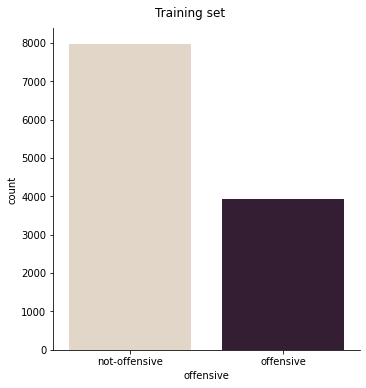

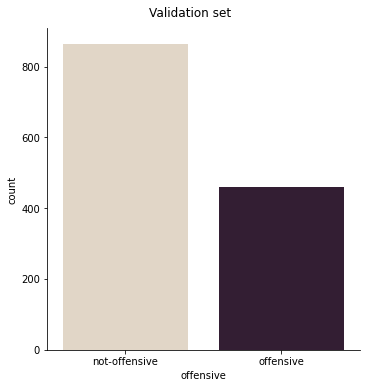

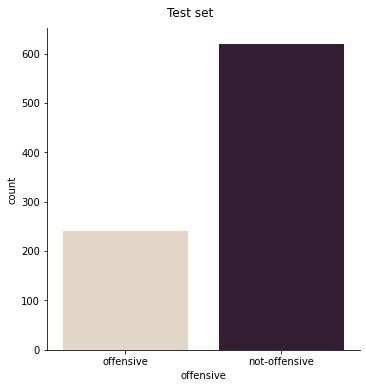

In [ ]:
g = (sns.catplot(x="offensive", kind="count", palette="ch:.25", data=off_combo_train))
g.fig.suptitle("Training set", y=1.03)
# g.savefig("off_train.png")
# files.download("off_train.png")
plt.show()

v = sns.catplot(x="offensive", kind="count", palette="ch:.25", data=off_combo_val)
v.fig.suptitle("Validation set", y=1.03)
# v.savefig("off_val.png")
# files.download("off_val.png")
plt.show()

t = sns.catplot(x="offensive", kind="count", palette="ch:.25", data=off_combo_test)
t.fig.suptitle("Test set", y=1.03)
# t.savefig("off_test.png")
#files.download("off_test.png")
plt.show()


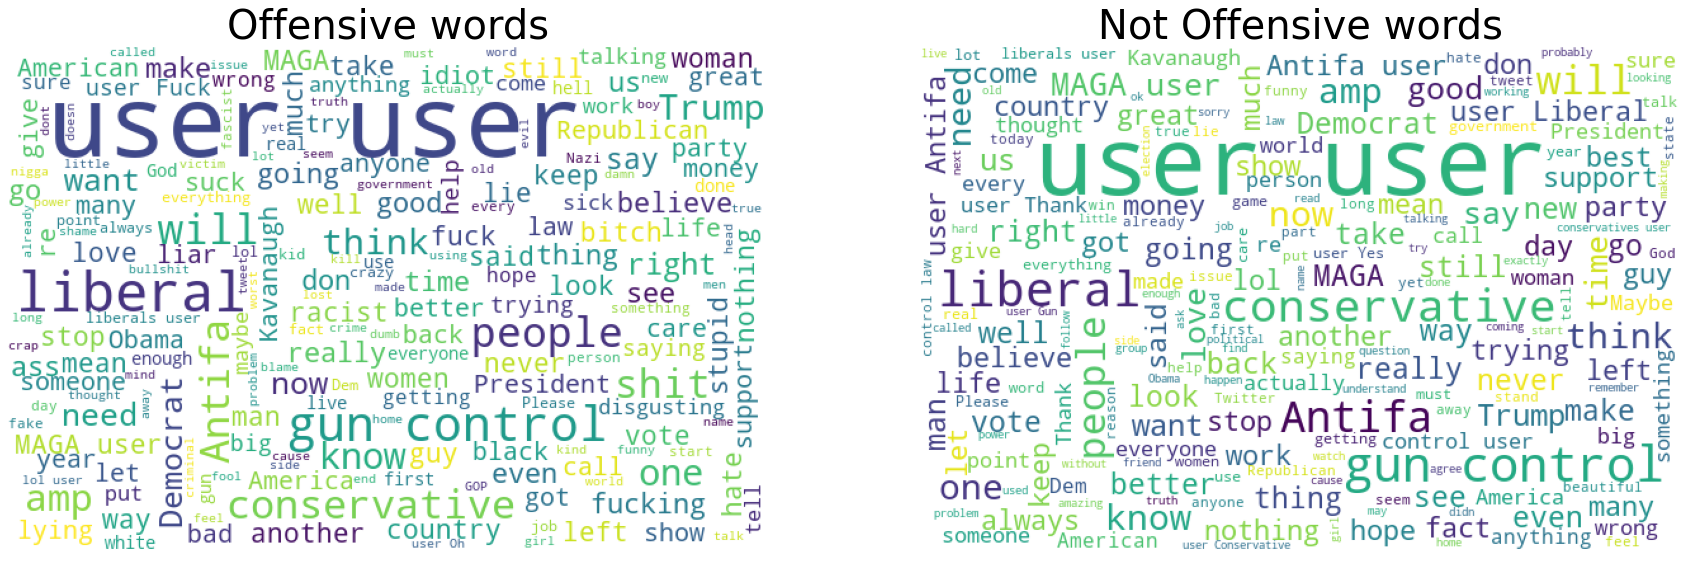

In [ ]:
# wordcloud for both classifications of Offensive dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(off_yes))
#wordcloud1.to_file('off_cloud.png')
#files.download('off_cloud.png')

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Offensive words',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(off_no))
# wordcloud2.to_file('non_off_cloud.png')
# files.download('non_off_cloud.png')
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Not Offensive words',fontsize=40);

 

In [ ]:
# getting top 20 words in both classifications of  Offensive dataset
top_offensive_words = get_top_n_words(off_yes)
top_nonOff_words = get_top_n_words(off_no)


s1 = [x[0] for x in top_offensive_words[:20]]
s2 = [x[1] for x in top_offensive_words[:20]]

a1 = [x[0] for x in top_nonOff_words[:20]]
a2 = [x[1] for x in top_nonOff_words[:20]]



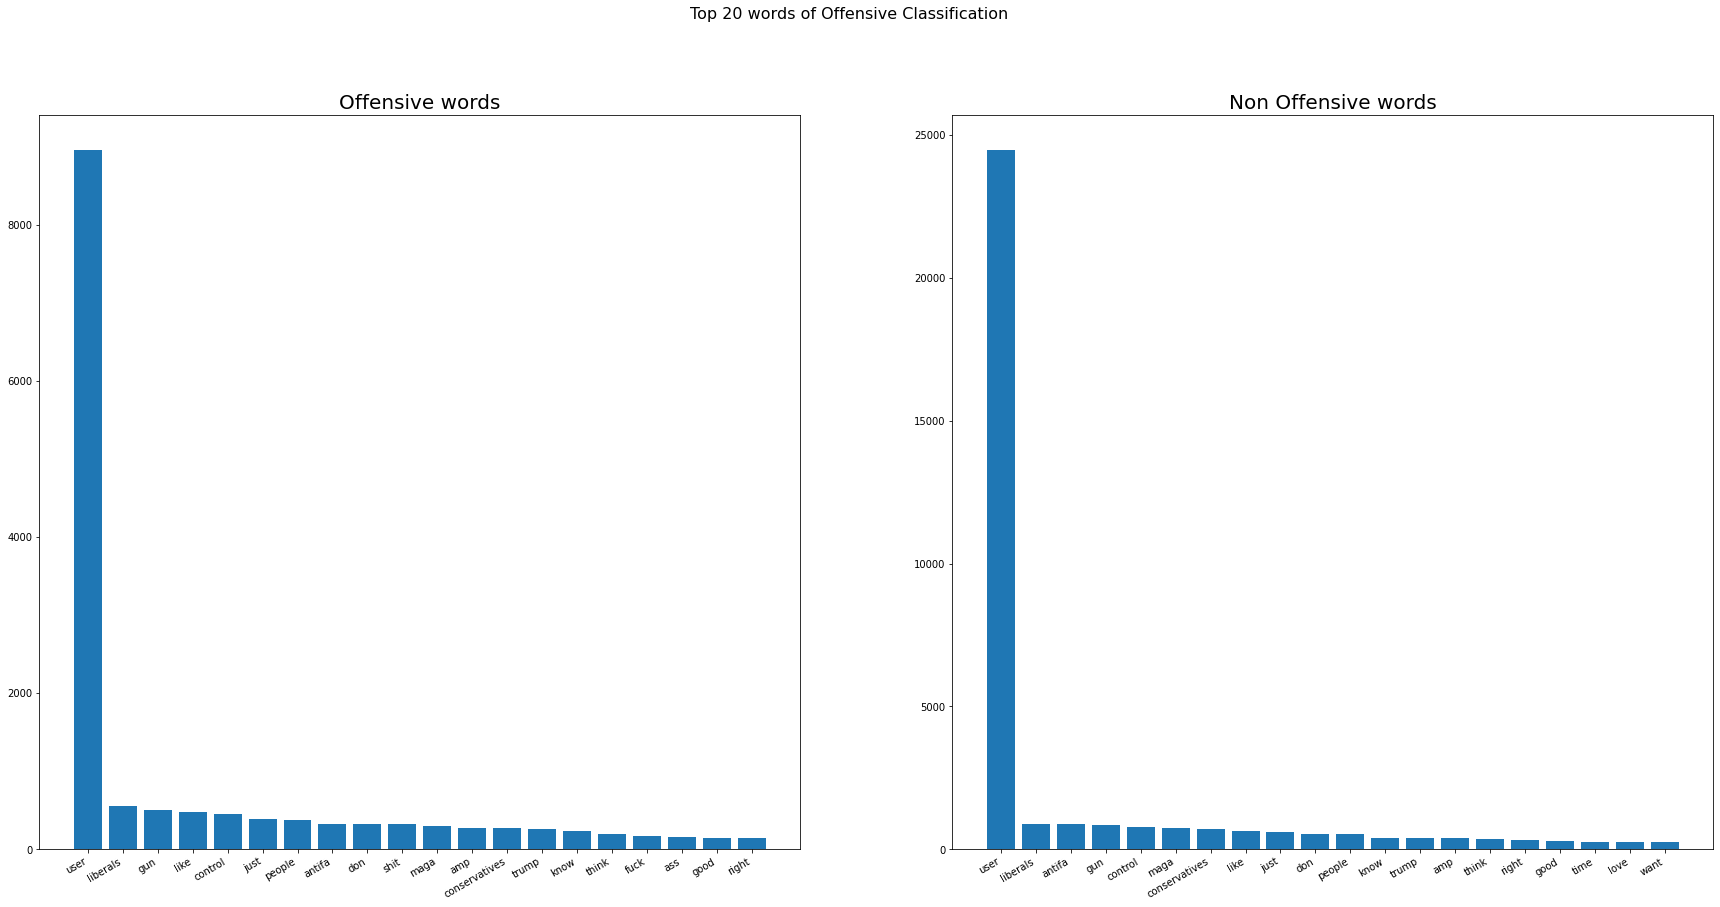

In [ ]:
#visualization for top 20 words in both classifications of  Offensive dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
fig.suptitle('Top 20 words of Offensive Classification',fontsize=16)
ax1.bar(s1, s2)


ax1.set_title('Offensive words',fontsize=20);
fig.autofmt_xdate()

ax2.bar(a1,a2)
ax2.set_title('Non Offensive words',fontsize=20);
fig.autofmt_xdate()





## *Training* the model and testing with macro averaged F1 score as evaluation metric.

### Data Cleaning

In [ ]:
off_combo_test

,tweet_text,tweet_label,offensive
0,#ibelieveblaseyford is liar she is fat ugly li...,1,offensive
1,". a grown ass woman, probably 10 years older t...",1,offensive
2,"#Kavanaugh is a disciple of Anthony Kennedy, w...",1,offensive
3,And apparently I'm committed to going to a new...,1,offensive
4,"50 Cent Calls Out Joe Budden's Bullshit"""" On I...",1,offensive
...,...,...,...
855,#Denver's venues are STACKED with epic shows t...,0,not-offensive
856,#CNN irrationally argues 4 legalising #abortio...,0,not-offensive
857,@user @user @user @user @user @user @user @use...,0,not-offensive
858,#antifa #Resist.. Trump is trying to bring wor...,0,not-offensive


In [ ]:
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

train_data = off_train_val[['tweet_text','offensive']]
test_data = off_combo_test[['tweet_text','offensive']]

# Setting stopwords
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

# Function to expand tweet
def expand_tweet(tweet):
	expanded_tweet = []
	for word in tweet:
		if re.search("n't", word):
			expanded_tweet.append(word.split("n't")[0])
			expanded_tweet.append("not")
		else:
			expanded_tweet.append(word)
	return expanded_tweet

# Function to process tweets
def clean_tweet(data, wordNetLemmatizer, porterStemmer):
	data['Clean_tweet'] = data['tweet_text']
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
	data['Clean_tweet'] = data['Clean_tweet'].str.split()
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [word for word in tweet if word not in STOPWORDS])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: expand_tweet(tweet))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [wordNetLemmatizer.lemmatize(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [porterStemmer.stem(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: ' '.join(tweet))
	return data


wordNetLemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

# pre-processing the tweets
train_data = clean_tweet(train_data, wordNetLemmatizer, porterStemmer)
test_data = clean_tweet(test_data, wordNetLemmatizer, porterStemmer)

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['Clean_tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['Clean_tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['Clean_tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)




### Model Training and Testing

In [ ]:
# Building the model
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(2, activation = 'softmax'))
#model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 47, 128)           256000    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 47, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 650,754
Trainable params: 650,754
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model
history = model.fit(train_tweets, pd.get_dummies(train_data['offensive']).values, epochs = 10, batch_size = 128)

# Testing the model

#score, accuracy = model.evaluate(test_tweets, pd.get_dummies(test_data['emotion']).values, batch_size = 128)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_tweets, pd.get_dummies(test_data['offensive']).values, batch_size = 128)
print("f1 score is {}".format(f1_score))

Epoch 1/10
104/104 [==============================] - 3s 14ms/step - loss: 0.6244 - accuracy: 0.6669 - f1_m: 0.6669 - precision_m: 0.6669 - recall_m: 0.6669
Epoch 2/10
104/104 [==============================] - 1s 13ms/step - loss: 0.4759 - accuracy: 0.7790 - f1_m: 0.7790 - precision_m: 0.7790 - recall_m: 0.7790
Epoch 3/10
104/104 [==============================] - 1s 13ms/step - loss: 0.4377 - accuracy: 0.8057 - f1_m: 0.8057 - precision_m: 0.8057 - recall_m: 0.8057
Epoch 4/10
104/104 [==============================] - 1s 13ms/step - loss: 0.4176 - accuracy: 0.8173 - f1_m: 0.8173 - precision_m: 0.8173 - recall_m: 0.8173
Epoch 5/10
104/104 [==============================] - 1s 13ms/step - loss: 0.3994 - accuracy: 0.8263 - f1_m: 0.8263 - precision_m: 0.8263 - recall_m: 0.8263
Epoch 6/10
104/104 [==============================] - 1s 13ms/step - loss: 0.3725 - accuracy: 0.8453 - f1_m: 0.8453 - precision_m: 0.8453 - recall_m: 0.8453
Epoch 7/10
104/104 [==============================] - 1s 1